# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 8
# Ensemble methods

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave


Enrollment: CS 109A

Import libraries:

In [64]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import accuracy_score
%matplotlib inline

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between a collision that produces Higgs bosons and collisions thats produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle colision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.


In [65]:
data_train = pd.read_csv('Higgs_train.csv')
data_test = pd.read_csv('Higgs_test.csv')

In [66]:
print(data_train.shape)
print(data_test.shape)

(5000, 29)
(5000, 29)


In [67]:
data_train_nda = data_train.as_matrix()

X_train = data_train_nda[:, :-1]
Y_train = data_train_nda[:, -1]

data_test_nda = data_test.as_matrix()

X_test = data_test_nda[:, :-1]
Y_test = data_test_nda[:, -1]

### EDA

In [68]:
data_train.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,...,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.376816,-1.583727,-1.707552,0.990897,0.114397,1.253553,0.619859,-1.479572,2.173076,0.753658,...,0.397156,0.000000,0.522449,1.318622,0.982398,1.359610,0.964809,1.309991,1.083203,1.0
1,0.707330,0.087603,-0.399742,0.918742,-1.229936,1.172847,-0.552574,0.886053,2.173076,1.298317,...,0.236231,0.000000,0.439696,0.828885,0.992241,1.157820,2.215780,1.189586,0.937976,1.0
2,0.617290,0.265839,-1.345227,1.154581,1.036646,0.954822,0.377252,-0.147960,0.000000,1.063507,...,-0.542413,0.000000,1.024506,1.026255,0.986289,0.927720,1.371080,0.981672,0.917436,1.0
3,0.850992,-0.380876,-0.071264,1.468704,-0.795133,0.691818,0.883260,0.496881,0.000000,1.616349,...,-1.520171,0.000000,1.197755,1.100534,0.987262,1.353453,1.455383,0.994682,0.953553,1.0
4,0.767540,-0.691572,-0.040191,0.614843,0.143765,0.748614,0.397057,-0.873640,0.000000,1.147862,...,0.502034,1.550981,0.921948,0.864080,0.982839,1.373222,0.601492,0.918621,0.957063,0.0


## Question 1 (2pt): Single Decision Tree
We start by building a basic model which we will use as our base model for comparison. 

1. Fit a decision tree model to the training set and report the classification accuracy of the model on the test set. Use 5-fold cross-validation to choose the (maximum) depth for the tree. You will use the max_depth you find here throughout the homework. 


In [69]:
from sklearn.model_selection import cross_val_score

# create an empty array to hold accuracy scores later
scores = []
depths = [2,3,4,5,6,7,8,9,10]

# for each depth, fit the tree classifier onto the train set
# use the cross_val_score method to directly perform cv and get the accuracy scores
for depth in depths:
    dt = DecisionTreeClassifier(max_depth = depth)
    cv_scores = cross_val_score(dt, X_train, Y_train, cv=5)
    scores.append(np.mean(cv_scores))

# format into data series
depths_se = pd.Series(depths)
scores_se = pd.Series(scores)

# create a dataframe for data presentation
col_names = ['Depths', 'Scores']
depths_scores_df = pd.DataFrame(columns = col_names)

depths_scores_df['Depths'] = depths_se.values
depths_scores_df['Scores'] = scores_se.values

depths_scores_df

,Depths,Scores
0,2,0.623207
1,3,0.620411
2,4,0.635806
3,5,0.639211
4,6,0.627406
5,7,0.629406
6,8,0.627600
7,9,0.624207
8,10,0.616805


In [70]:
best_depth = 5
dt = DecisionTreeClassifier(max_depth = best_depth)
dt.fit(X_train, Y_train)
dt.score(X_test, Y_test)

0.64539999999999997

## Question 2 (15pt): Dropout-based Approach
We start with a simple method inspired from the idea of 'dropout' in machine learning, where we fit multiple decision trees on random subsets of predictors, and combine them through a majority vote. The procedure is described below.

- For each predictor in the training sample, set the predictor values to 0 with probability $p$  (i.e. drop the predictor by setting it to 0). Repeat this for $B$ trials to create $B$ separate training sets.


- Fit decision tree models $\hat{h}^1(x), \ldots, \hat{h}^B(x) \in \{0,1\}$ to the $B$ training sets. 

- Combine the decision tree models into a single classifier by taking a majority vote:
$$
\hat{H}_{maj}(x) \,=\, majority\Big(\hat{h}^1(x), \ldots, \hat{h}^B(x)\Big).
$$


We shall refer to the combined classifier as an ** *ensemble classifier* **. Implement the described dropout approach, and answer the following questions:
1. Apply the dropout procedure with $p = 0.5$ for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracy of the combined classifier. Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.
- Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.
- Apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees. How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?
[hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

### Part 2.1

In [71]:

# re-handle the data for safety, split to train and test

data_train = pd.read_csv('Higgs_train.csv')
data_test = pd.read_csv('Higgs_test.csv')

data_train_nda = data_train.as_matrix()

X_train = data_train_nda[:, :-1]
Y_train = data_train_nda[:, -1]

data_test_nda = data_test.as_matrix()

X_test = data_test_nda[:, :-1]
Y_test = data_test_nda[:, -1]
    

In [72]:
import copy
import random

# best depth found in q1
depth = 5

# function to ensemble predict on our data 
def dropout_procedure(num_trees, dropout_rate, X, Y, X_test, Y_test):
        
    # num_trees is b- the number of models we build
    train_predictions = np.zeros((num_trees, len(X)))
    test_predictions = np.zeros((num_trees, len(X_test)))
    final_train_prediction = []
    final_test_prediction = []
    
    # loop through B times
    for i in range(num_trees):        
        model_X = copy.deepcopy(X)
        model_X_test = copy.deepcopy(X_test)
        
        for j in range(len(model_X[0])):
            rand = random.uniform(0,1)
            # drop with the specified probability
            if rand < dropout_rate:
                # dropout column- set to 0 
                for k in range(len(model_X)):
                    model_X[k][j] = 0
                
        # fit classifier
        dt = DecisionTreeClassifier(max_depth = depth)
        dt.fit(model_X, Y)
        train_predict = dt.predict(model_X)
        test_predict = dt.predict(model_X_test)
        # put together
        train_predictions[i,:] = train_predict
        test_predictions[i,:] = test_predict
        
    
    for i in range(len(model_X)):   
        # add up ones
        sum_one = 0
        for j in range(num_trees):
            sum_one = sum_one + train_predictions[j][i]
        
        # if more than .5 classified as 1, classify as 1, otherwise 0
        if (1.0*sum_one/num_trees) > 0.5:
            final_train_prediction.append(1.0)
        else:
            final_train_prediction.append(0.0)
            
    for i in range(len(model_X_test)):   
        # add up ones
        sum_one = 0
        for j in range(num_trees):
            sum_one = sum_one + test_predictions[j][i]
        
        # if more than .5 classified as 1, classify as 1, otherwise 0
        if (1.0*sum_one/num_trees) > 0.5:
            final_test_prediction.append(1.0)
        else:
            final_test_prediction.append(0.0)
            
    train_acc = accuracy_score(Y, final_train_prediction)
    test_acc = accuracy_score(Y_test, final_test_prediction)
        
    return (train_acc, test_acc)
    

In [73]:
# part 1, for many different values of B

num_trees_to_test = [2,4,8,16,32,64,128,256]

train_accs = []
test_accs = []
trees = []

# loop through desired # trees
for num_trees in num_trees_to_test:
    
    # collect data using function
    train_acc, test_acc = dropout_procedure(num_trees, 0.5, X_train, Y_train, X_test, Y_test)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
# display the data
data_table = np.transpose([num_trees_to_test, train_accs, test_accs])
x = pd.DataFrame(data_table, columns=["Number of Trees","Train Accuracy", "Test Accuracy"])
print("Data for varied number of trees, dropout rate 0.5")
x

Data for varied number of trees, dropout rate 0.5


,Number of Trees,Train Accuracy,Test Accuracy
0,2.0,0.6436,0.5928
1,4.0,0.6798,0.6504
2,8.0,0.7182,0.6738
3,16.0,0.7278,0.6728
4,32.0,0.7294,0.6810
5,64.0,0.7430,0.6892
6,128.0,0.7412,0.6880
7,256.0,0.7370,0.6882


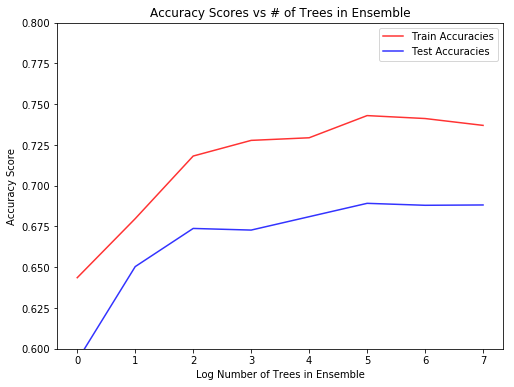

In [74]:
# plot train and test accuracy

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(train_accs, color='red', alpha=0.8, label='Train Accuracies')
ax.plot(test_accs, color='blue', alpha=0.8, label='Test Accuracies')
ax.set_title('Accuracy Scores vs # of Trees in Ensemble')
ax.set_xlabel('Log Number of Trees in Ensemble')
ax.set_ylabel('Accuracy Score')
ax.set_ylim(0.6,0.8)
ax.legend(loc='best')
plt.show()

### Part 2.2

#### Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.

In [75]:
# part 2, for many different values of dropout_rate
num_trees = 64

train_accs_2 = []
test_accs_2 = []
dropout_rates = [0.1,0.3,0.5,0.7,0.9]

# iterate through dropout rates
for dropout_rate in dropout_rates:
    
    # collect data with function
    train_acc_2, test_acc_2 = dropout_procedure(num_trees, dropout_rate, X_train, Y_train, X_test, Y_test)
    train_accs_2.append(train_acc_2)
    test_accs_2.append(test_acc_2)
    
# visualize data
data_table_2 = np.transpose([dropout_rates, train_accs_2, test_accs_2])
x2 = pd.DataFrame(data_table_2, columns=["Dropout Rate","Train Accuracy", "Test Accuracy"])
print("Data for varied dropout rate, 64 trees")
x2

Data for varied dropout rate, 64 trees


,Dropout Rate,Train Accuracy,Test Accuracy
0,0.1,0.6816,0.6456
1,0.3,0.6986,0.6546
2,0.5,0.7352,0.6944
3,0.7,0.7390,0.6758
4,0.9,0.6040,0.5746


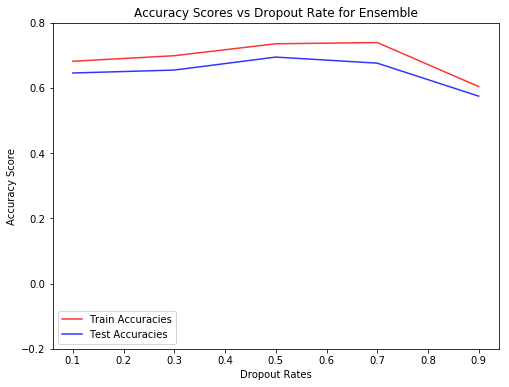

In [76]:
# plot training and test data

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(dropout_rates, train_accs_2, color='red', alpha=0.8, label='Train Accuracies')
ax.plot(dropout_rates, test_accs_2, color='blue', alpha=0.8, label='Test Accuracies')
ax.set_title('Accuracy Scores vs Dropout Rate for Ensemble')
ax.set_xlabel('Dropout Rates')
ax.set_ylabel('Accuracy Score')
ax.set_ylim(-0.2,0.8)
ax.legend(loc='best')
plt.show()

### Part 2.3

In [77]:
from sklearn.cross_validation import KFold

# 5 fold CV to select best combo of trees and dropout rate
# in part 2.1, we hit our top accuacy at 64 trees, so we should cap it at 64

data_train = pd.read_csv('Higgs_train.csv')
data_test = pd.read_csv('Higgs_test.csv')

tree_options = [2,4,8,16,24,32,48,64]
dropout_rates = [0.1,0.3,0.5,0.7,0.9]

trees = []
rates = []
valids = []

# iterate through trees and dropout rates
for num_trees in tree_options:
    for dropout_rate in dropout_rates:
        
        # use KFold for cross validation 
        n = len(X_train)
        test_acc_total = 0
        for f_train, f_test in KFold(n, n_folds=5, shuffle=False, random_state=11):
            
            # prepare data
            train_data = data_train.iloc[f_train]
            valid_data = data_train.iloc[f_test]
            
            data_train_nda = train_data.as_matrix()
            data_valid_nda = valid_data.as_matrix()

            train_x = data_train_nda[:, :-1]
            train_y = data_train_nda[:, -1]
            valid_x = data_test_nda[:, :-1]
            valid_y = data_test_nda[:, -1]

            # collect accuracy from function
            train_acc, valid_acc = dropout_procedure(num_trees, dropout_rate, train_x, train_y, valid_x, valid_y)  
            test_acc_total += valid_acc
        
        # collect data for visualization
        test_acc_final = test_acc_total / 5.0
        trees.append(num_trees)
        rates.append(dropout_rate)
        valids.append(test_acc_final)

# print sorted results        
data_table_3 = np.transpose([trees, rates, valids])
x3 = pd.DataFrame(data_table_3, columns=["Number of Trees","Dropout Rate", "Validation Accuracy"])
print("5-fold Cross Validation Accuracy for various numbers of trees and dropout rates")
print("Sorted so that the best accuracy is a the top!")
x3.sort_values(by="Validation Accuracy", ascending=False)

5-fold Cross Validation Accuracy for various numbers of trees and dropout rates
Sorted so that the best accuracy is a the top!


,Number of Trees,Dropout Rate,Validation Accuracy
22,24.0,0.5,0.67792
37,64.0,0.5,0.67700
32,48.0,0.5,0.67540
27,32.0,0.5,0.67324
17,16.0,0.5,0.66872
16,16.0,0.3,0.66744
36,64.0,0.3,0.66740
38,64.0,0.7,0.66684
33,48.0,0.7,0.66652
21,24.0,0.3,0.66644


3D Visualization for this data. The above sorted table 
is a much cleaner way to understand the results


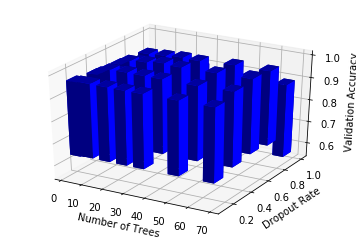

In [124]:
from mpl_toolkits.mplot3d import Axes3D

print("3D Visualization for this data. The above sorted table ")
print("is a much cleaner way to understand the results")

d = np.ones(len(rates))
d1 = d*.1
d2 = d*5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x=trees, y=rates, z=valids, dx=d2, dy=d1, dz=0.33, color='b', zsort='average')
ax.set_ylabel("Dropout Rate")
ax.set_zlabel("Validation Accuracy")
ax.set_xlabel("Number of Trees")
plt.show()

In [79]:
# in the previous problem, the highest validation accuracy is for 24 trees and 0.5 dropout rate

# re-handle the data for safety, split to train and test

data_train = pd.read_csv('Higgs_train.csv')
data_test = pd.read_csv('Higgs_test.csv')

data_train_nda = data_train.as_matrix()

X_train = data_train_nda[:, :-1]
Y_train = data_train_nda[:, -1]

data_test_nda = data_test.as_matrix()

X_test = data_test_nda[:, :-1]
Y_test = data_test_nda[:, -1]

optimal_trees = 24
optimal_dropout_rate = 0.5

# use the function to again train and test on the real test data
train_acc, test_acc = dropout_procedure(optimal_trees, optimal_dropout_rate, X_train, Y_train, X_test, Y_test)
print("For optimal trees: {} and optimal dropout rate: {}, train accuracy is {} and test accuracy is {}".format(optimal_trees, optimal_dropout_rate, train_acc, test_acc))    



For optimal trees: 24 and optimal dropout rate: 0.5, train accuracy is 0.7316 and test accuracy is 0.6772


## Analysis: 

#### Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.

Results printed above in 2.1. 

Here, for all num_trees from 16 to 256, we get essentailly the same test accuracy but 16 trees by far runs the fastest, so I would say anywhere from 16-64 trees is a good number to avoid a crazy runtime, but still get great test results, which are all considerably higher than the 0.639 that we saw in the original one tree model. Based on this procedure, it seems that more trees would lead to a lower bias and a higher variance in our predictions. Lower bias because using so many different trees will average each other's bias out and "center us on the bullseye" on average. However, using so many trees likely leads to higher variance because our predictions will vary greatly across the tree, and majority rule will greatly spread out any point that is near 50-50 for votes. Overall, we see these two affects approximately cancel each other out past ~16 trees, and our train and test accuracy remain about the same. 


#### Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.

Results printed above in 2.2. 

So rate of 0.5 is clearly the best here in terms of test performance, and both train and test accuracy decrease sharply when dropout rate increases or decreases away from 0.5. Low dropout rate has relatively higher performance, especially for the training data so I would say that low dropout rate leads to high bias, since then our predictions simply match the trees we were using before, without adding the benefit of randomness that we see with this model. Essentially, low dropout rate just fails to solve the issue that these trees are all slightly biased. We see this high bias, because for 0.1 rate, train and test accuracy are relatively high and similar, just not as good as our optimal model. High dropout rate leads to very high variance because when we only use a few predictors in each tree, we spread out our predictions and they will not be tightly packed together because we are predicting on only a very small amount of data. 

#### How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?

Results printed above in 2.3

With our optimal model (48 trees, 0.5 dropout rate), we get a test accuracy of 0.6772, which is considerably better than the best model we saw in part 1, which had accuracy 0.639.


## Question 3 (15pt): Random Forests

We now move to a more sophisticated ensemble technique, namely random forest:
1. How does a random forest approach differ from the dropout procedure described in Question 2? 
 
- Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

- Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier. 
  
- Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the  number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?  




### Part 3.1

#### How does a random forest approach differ from the dropout procedure described in Question 2? 

Both approaches involve bootstrap aggregation, but the random forest approach involves random selection of predictors while the dropout procedure only approximates this random selection. Instead, in the dropout procedure, we select the predictors at each split by iterating through all possible predictors. At each possible predictor, we make an **independent** decision (based on a preset probability) as to whether we use it or not. In the random forest approach, we select a subset of predictors from the overall set; selection of predictors is **dependent** since we have a preset number of predictors we select at each split.

In Practice: If we had 20 predictors, we could set a dropout rate of 0.5 and end up with X predictors at one split and Y predictors at another (for instance, 8 predictors at one split and 12 at another), but if we used the random forest approach and predetermined that we will select 10 predictors, we will necessarily have a subset of 10 predictors at every split.

### Part 3.2

#### Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

In [90]:
# pick num of predictors to use at each split; round sqrt(28) up to 6
num_rf_pred = int(np.ceil(np.sqrt(X_train.shape[1])))

# create empty lists to input training and test accuracy scores into
rf_tr_score = []
rf_te_score = []

# run the model with different numbers of trees, use first 8 powers of 2
for i in range(1,9):
    rf = ensemble.RandomForestClassifier(n_estimators=(2**i), 
                                         max_features = num_rf_pred, 
                                         max_depth = best_depth)
    rf.fit(X_train, Y_train)
    rf_tr_score.append(rf.score(X_train, Y_train))
    rf_te_score.append(rf.score(X_test, Y_test))

In [91]:
# format into data series
number_trees_se = pd.Series([2,4,8,16,32,64,128,256])
train_scores_se = pd.Series(rf_tr_score)
test_scores_se = pd.Series(rf_te_score)

# create a dataframe for data presentation
col_names = ['# of Trees', 'Train Accuracies', 'Test Accuracies']
rf_scores_df = pd.DataFrame(columns = col_names)

rf_scores_df['# of Trees'] = number_trees_se.values
rf_scores_df['Train Accuracies'] = train_scores_se.values
rf_scores_df['Test Accuracies'] = test_scores_se.values

rf_scores_df

,# of Trees,Train Accuracies,Test Accuracies
0,2,0.6732,0.6290
1,4,0.6804,0.6590
2,8,0.7204,0.6706
3,16,0.7234,0.6806
4,32,0.7382,0.6886
5,64,0.7424,0.6930
6,128,0.7378,0.6986
7,256,0.7380,0.6990


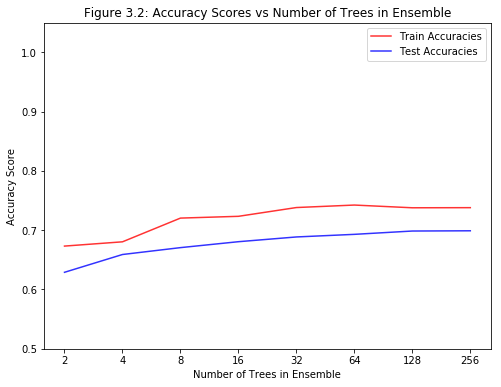

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(rf_tr_score, color='red', alpha=0.8, label='Train Accuracies')
ax.plot(rf_te_score, color='blue', alpha=0.8, label='Test Accuracies')
ax.set_title('Figure 3.2: Accuracy Scores vs Number of Trees in Ensemble')
ax.set_xlabel('Number of Trees in Ensemble')
ax.set_ylabel('Accuracy Score')
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_xticklabels(['2','4','8','16','32','64','128','256'])
ax.set_ylim(0.5,1.05)
ax.legend(loc='best')
plt.show()

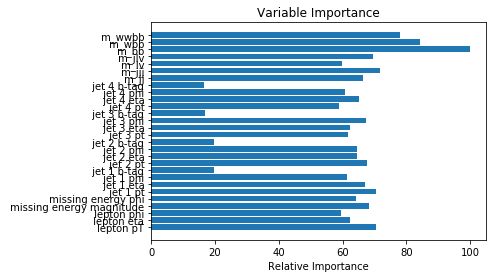

In [142]:
rf = ensemble.RandomForestClassifier(n_estimators=32, max_features=1, oob_score=True)
rf.fit(X_train, Y_train)

feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# sorted_idx = np.argsort(feature_importance)
# pos = np.arange(sorted_idx.shape[0]) + .5

# plt.barh(pos, feature_importance[sorted_idx], align='center')
# plt.yticks(pos, X_train.columns[sorted_idx])

plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, data_train.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

### Part 3.3

#### Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees affects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier. 

A larger number of trees **will not** necessarily improve the test accuracy of a random forest model, because at some point after we have added a large number of trees into the model already, we are susceptible to start adding duplicate trees. I can see this happening if there are a couple predictors that are really strong at explaining the response variable, and they show up consistently in our tree even when we take a subset of the predictors at the very beginning.

Before we reach this point when we start adding duplicate trees into the model, we see that using larger number of trees generally leads to higher training and test accuracies. In *Figure 3.2*, we notice that both training and test accuracies improve by > 0.04 when we go from using 2 trees to using 8 trees. In contrast, when we go from using 128 trees to using 256 trees, our accuracies go up by < 0.001.

In terms of bias and variance, when we go from using 2 trees to using 8 trees, we are **lowering the bias and increasing the variance**. We know that bias is decreasing since our accuracy scores are improving, but this comes at the However, when we start adding duplicate trees, we will no longer lower the bias of our model since the information from that tree was already used the first time we added it. Therefore, the variances will not increase either; this makes sense we know that random forests model avoid overfitting on the training data. Looking at *Figure 3.2*, we see this idea supported by the fact that the training and test accuracies flatten out but do not decrease. 

### Part 3.4

#### Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the number of predictors.

In [40]:
scores = []
optimal_num = 0

for features in range(1,X_train.shape[1]+1):
    rfc = ensemble.RandomForestClassifier(n_estimators=32, max_features = features, oob_score=True)
    # Perform 5-fold cross validation 
    cv_scores = cross_val_score(rfc, X_train, Y_train, cv=5)
    if features > 1 and np.mean(cv_scores) >= max(scores):
        optimal_num = features
    scores.append(np.mean(cv_scores))
    print(features)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [41]:
print(scores)
print()
print(optimal_num)

[0.63380450840450842, 0.65020332280332283, 0.6634087282087282, 0.66380293160293158, 0.66540473140473133, 0.67340813760813767, 0.666807332007332, 0.66560513180513181, 0.67500194060194063, 0.67300393580393592, 0.6782003422003422, 0.67280473660473661, 0.67240414000413995, 0.67940754300754302, 0.67100793500793499, 0.66720153580153574, 0.67440133840133842, 0.67540233620233614, 0.671797134997135, 0.66660973240973243, 0.66340092880092882, 0.67680053880053881, 0.66400072860072856, 0.66680613400613398, 0.67140493440493443, 0.6739983381983381, 0.66140672620672625, 0.65859892479892479]

14


In [57]:
best_rfc = ensemble.RandomForestClassifier(n_estimators=32, max_features = optimal_num, oob_score=True)
best_rfc.fit(X_train, Y_train)
print('Train Score: ', best_rfc.score(X_train, Y_train))
print('Test Score: ', best_rfc.score(X_test, Y_test))

Train Score:  0.9994
Test Score:  0.6806


#### ANALYSIS: How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?



## Question 4 (15pt): Boosting

We next compare the random forest model with the approach of boosting:


1. Apply the AdaBoost algorithm to fit an ensemble of decision trees. Set the learning rate to 0.05, and try out different tree depths for the base learners: 1, 2, 10, and unrestricted depth.  Make a plot of the training accuracy of the ensemble classifier as a function of tree depths. Make a similar plot of the test accuracies as a function of number of trees (say $2, 4, 8, 16, \ldots, 256$).
- How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.
- How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.
- Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4? 


### Part 4.1

In [128]:
depths = [1,2,10,None]

ab_depths_tr_scores = []
ab_depths_te_scores = []

for depth in depths:
    adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=depth), 
                                           n_estimators=32, learning_rate=0.05)
    adaboost.fit(X_train, Y_train)
    ab_depths_tr_scores.append(adaboost.score(X_train, Y_train))
    ab_depths_te_scores.append(adaboost.score(X_test, Y_test))

/Users/georgeh85/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


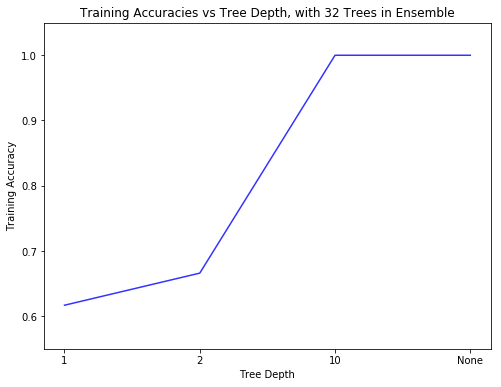

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([0,1,2,3], ab_depths_tr_scores, color='blue', alpha=0.8)
ax.set_title('Training Accuracies vs Tree Depth, with 32 Trees in Ensemble')
ax.set_ylabel('Training Accuracy')
ax.set_xlabel('Tree Depth')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['1','2','10','None'])
ax.set_ylim(0.55,1.05)
ax.legend()
plt.show()

#### Test num of trees and tree depth together

In [58]:
trees = [2,4,8,16,32,64,128,256]
depths = [1,2,10,None]

# train scores
ab_depth_1_tr_scores = []
ab_depth_2_tr_scores = []
ab_depth_10_tr_scores = []
ab_depth_no_tr_scores = []

# test scores
ab_depth_1_te_scores = []
ab_depth_2_te_scores = []
ab_depth_10_te_scores = []
ab_depth_no_te_scores = []

for num_trees in trees:
    adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                           n_estimators=num_trees, learning_rate=0.05)
    adaboost.fit(X_train, Y_train)
    ab_depth_1_tr_scores.append(adaboost.score(X_train, Y_train))
    ab_depth_1_te_scores.append(adaboost.score(X_test, Y_test))
    
for num_trees in trees:
    adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=2), 
                                           n_estimators=num_trees, learning_rate=0.05)
    adaboost.fit(X_train, Y_train)
    ab_depth_2_tr_scores.append(adaboost.score(X_train, Y_train))
    ab_depth_2_te_scores.append(adaboost.score(X_test, Y_test))
    
for num_trees in trees:
    adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=10), 
                                           n_estimators=num_trees, learning_rate=0.05)
    adaboost.fit(X_train, Y_train)
    ab_depth_10_tr_scores.append(adaboost.score(X_train, Y_train))
    ab_depth_10_te_scores.append(adaboost.score(X_test, Y_test))
    
for num_trees in trees:
    adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=None), 
                                           n_estimators=num_trees, learning_rate=0.05)
    adaboost.fit(X_train, Y_train)
    ab_depth_no_tr_scores.append(adaboost.score(X_train, Y_train))
    ab_depth_no_te_scores.append(adaboost.score(X_test, Y_test))

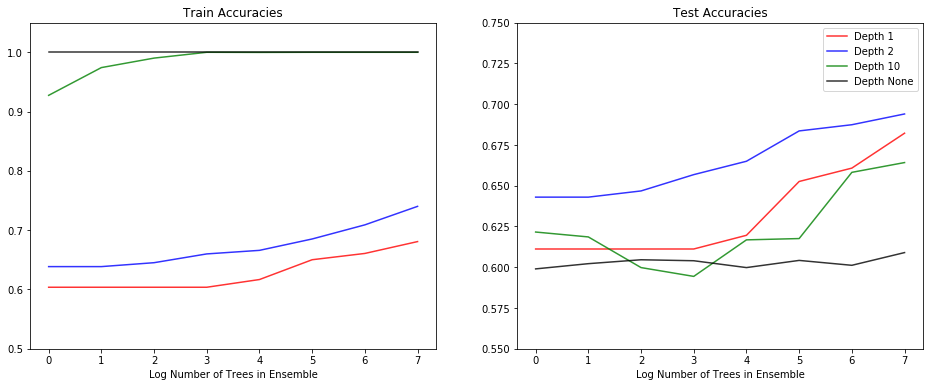

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(ab_depth_1_tr_scores, color='red', alpha=0.8, label='Depth 1')
ax[0].plot(ab_depth_2_tr_scores, color='blue', alpha=0.8, label='Depth 2')
ax[0].plot(ab_depth_10_tr_scores, color='green', alpha=0.8, label='Depth 10')
ax[0].plot(ab_depth_no_tr_scores, color='black', alpha=0.8, label='Depth None')
ax[0].set_title('Train Accuracies')
ax[0].set_xlabel('Log Number of Trees in Ensemble')
ax[0].set_ylim(0.5,1.05)
ax[1].plot(ab_depth_1_te_scores, color='red', alpha=0.8, label='Depth 1')
ax[1].plot(ab_depth_2_te_scores, color='blue', alpha=0.8, label='Depth 2')
ax[1].plot(ab_depth_10_te_scores, color='green', alpha=0.8, label='Depth 10')
ax[1].plot(ab_depth_no_te_scores, color='black', alpha=0.8, label='Depth None')
ax[1].set_title('Test Accuracies')
ax[1].set_xlabel('Log Number of Trees in Ensemble')
ax[1].set_ylim(0.55,0.75)
ax[1].legend()
plt.show()

### Part 4.2: 
#### How does the number of trees influence the training and test performance? 

As the number of trees increases from 2 to 256, the training performance steadily improves across all max tree depths (or stays constant once it reaches 1.0 accuracy). The test performance also improves as the number of trees increases, but this improvement is only consistent for models with max depths of 1 or 2. For max depth 10 and no max depth, a lot of the explained 

#### Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.



### Part 4.3

#### How does the tree depth of the base learner impact the training and test performance? 

The tree depth has a big impact on the training performance, since the model overfits on the training set when the max_depth is high. For instance, when there is no max depth, the algorithm immediately tries to explain all of the variation in the entire training set by making more and more splits in just the first tree. A similar thing happens when max_depth = 10, as we reach a 1.0 accuracy score on the training set by the time we add our 8th tree into the ensemble. Models with max_depth = 1 or 2, however, never reach a 1.0 accuracy score even when 256 trees have been added into the ensemble.

This overfitting problem is clear in the test performance of the models, as the one with max_depth = 1 performs the best (accuracy score ranging from 0.64 to 0.70) while the one with no max depth performs the worst (score ranging from 0.60 to 0.61). When we have no max depth, or a high max depth, we also don't see substantial improvements in the model as we add more trees into the ensemble. This is because the model overfits on the training set early on, with many splits in each tree, and we can't undo this overfitting. 

Overall, we can conclude that setting a **lower max_depth** helps us avoid overfitting on the training set, and allows us to better take advantage of the aggregate process of boosting.
 
#### Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.

No, since allowing higher tree depths in boosting leads to overfitting. The random forest approach naturally avoids overfitting since we are averaging many different models, but because boosting is a one-by-one, aggregate process instead of an averaging process, we need to avoid taking too many splits in each tree and overfitting on the training set with just a few trees in the ensemble.

### Part 4.4

#### Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4? 

In [88]:
optimal_num_trees = 0
optimal_tree_depth = 0

scores = [0]

for depth in depths:
    for num_trees in trees:
        adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=depth), 
                                               n_estimators=num_trees, learning_rate=0.05)
        cv_scores = cross_val_score(adaboost, X_train, Y_train, cv=5)
      
        if np.mean(cv_scores) >= max(scores):
            optimal_num_trees = num_trees
            optimal_tree_depth = depth
            
        scores.append(np.mean(cv_scores))
    

In [ ]:
print(optimal_num_trees)
print(optimal_tree_depth)

In [ ]:
adaboost_opt = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=optimal_tree_depth), 
                                           n_estimators=optimal_num_trees, learning_rate=0.05)
adaboost_opt.fit(X_train, Y_train)
print(adaboost_opt.score(X_train, Y_train))
print(adaboost_opt.score(X_test, Y_test))

# 0.694

## Question 5 (3pt): Meta-classifier

We have so far explored techniques that grow a collection of trees either by creating multiple copies of the original training set, or through a sequential procedure, and then combines these trees into a single classifier. Consider an alternate scenario where you are provided with a pre-trained collection of trees, say from different participants of a data science competition for Higgs boson discovery. What would be a good strategy to combine these pre-fitted trees into a single powerful classifier? Of course, a simple approach would be to take the majority vote from the individual trees. Can we do better than this simple combination strategy?

A collection of 100 decision tree classifiers is provided in the file `models.npy` and can be loaded into an array by executing:

`models = np.load('models.npy')`

You can make predictions using the $i^\text{th}$ model on an array of predictors `x` by executing:

`model[i].predict(x)`  &nbsp;&nbsp;&nbsp;
or &nbsp;&nbsp;&nbsp;
`model[i].predict_proba(x)`

and score the model on predictors `x` and labels `y` by using:

`model[i].score(x, y)`.

1. Implement a strategy to combine the provided decision tree classifiers, and compare the test perfomance of your approach with the majority vote classifier. Explain your strategy/algorithm.


In [70]:
models = np.load('models.npy', encoding='latin1')

In [71]:
# baseline majority rules

# put predictions together in a matrix
test_predictions = np.zeros((len(models), len(X_test)))
for i in range(len(models)):
    pred = models[i].predict(X_test)
    test_predictions[i,:] = pred

# loop through, sum up predictions
maj_prediction = []
for i in range(len(X_test)):
    num_1 = sum(test_predictions[:,i])
    prob = num_1 / len(models)
    
    # if more than half say 1, predict as 1 else 0
    if prob > 0.5:
        maj_prediction.append(1.0)
    else:
        maj_prediction.append(0.0)
        
print("Baseline test accuracy: {}".format(accuracy_score(maj_prediction, Y_test)))
        
    

Baseline test accuracy: 0.6646


In [72]:
# try bias toward 1, since there are more 1s in the training set

# sample_percent_1 is the bias. If >0.5, bias toward predicting 1, else 0

sample_percent_1 = sum(Y_train)/len(Y_train)
print("Percent of 1s in the training set: {}".format(sample_percent_1))
print("So we will bias slighly toward selecting 1s in the model")

test_predictions = np.zeros((len(models), len(X_test)))
for i in range(len(models)):
    pred = models[i].predict(X_test)
    test_predictions[i,:] = pred

maj_prediction = []
for i in range(len(X_test)):
    num_1 = sum(test_predictions[:,i])
    prob = num_1 / len(models)
    
    # so now, predict as 1 if more than ~0.475 say it is 1,
    # have to be .525 confident to predict 0
    if prob > (1 - sample_percent_1):
        maj_prediction.append(1.0)
    else:
        maj_prediction.append(0.0)
        
print("Biased test accuracy: {}".format(accuracy_score(maj_prediction, Y_test)))
        

Percent of 1s in the training set: 0.5246
So we will bias slighly toward selecting 1s in the model
Biased test accuracy: 0.6646


In [73]:
# majority rules, but only use some of the trees (best performing on training set)


# collect list of scores for each model
scores = []
for j in range(len(models)):
    pred = models[j].predict(X_train)
    score = accuracy_score(pred, Y_train)
    scores.append(score)
    
# select the top i scoring trees, run on training set
overall = []
for i in range(1,100):
    indices = np.argpartition(scores, -i)[-i:]

    train_predictions = np.zeros((len(indices), len(X_train)))
    for i in range(len(indices)):
        pred = models[i].predict(X_train)
        train_predictions[i,:] = pred
    
    maj_prediction = []
    for i in range(len(X_train)):
        num_1 = sum(train_predictions[:,i])
        prob = num_1 / len(indices)
        if prob > 0.5:
            maj_prediction.append(1.0)
        else:
            maj_prediction.append(0.0)
            
    overall.append(accuracy_score(maj_prediction, Y_train))

# pick the # trees with the highest accuracy
max_acc = max(overall)
max_trees = overall.index(max(overall))
print("Max train acc: {} at {} trees".format(max_acc, max_trees))

# so use 44 trees 

# now run on the test data with this new number of trees
indices = np.argpartition(scores, -max_trees)[-max_trees:]
test_predictions = np.zeros((len(indices), len(X_test)))
for i in range(len(indices)):
    pred = models[i].predict(X_test)
    test_predictions[i,:] = pred
    
    maj_prediction = []
    for i in range(len(X_test)):
        num_1 = sum(test_predictions[:,i])
        prob = num_1 / len(indices)
        if prob > 0.5:
            maj_prediction.append(1.0)
        else:
            maj_prediction.append(0.0)
            
print("New score: {}".format(accuracy_score(maj_prediction, Y_test)))


Max train acc: 0.6646 at 44 trees
New score: 0.663


In [74]:
# we will only use some of the trees (best performing on training set)
# in addition, we will bias this time toward 1 instead of majority rules
# essentially comining the last two methods

sample_percent_1 = sum(Y_train)/len(Y_train)
print("Percent of 1s in the training set: {}".format(sample_percent_1))
print("So we will bias slighly toward selecting 1s in the model")

# collect scores
scores = []
for j in range(len(models)):
    pred = models[j].predict(X_train)
    score = accuracy_score(pred, Y_train)
    scores.append(score)
    
# select the top i scoring trees, run on training set
overall = []
for i in range(1,100):
    indices = np.argpartition(scores, -i)[-i:]

    train_predictions = np.zeros((len(indices), len(X_train)))
    for i in range(len(indices)):
        pred = models[i].predict(X_train)
        train_predictions[i,:] = pred
    
    maj_prediction = []
    for i in range(len(X_train)):
        num_1 = sum(train_predictions[:,i])
        prob = num_1 / len(indices)
        
        # include bias toward 1
        if prob > (1 - sample_percent_1):
            maj_prediction.append(1.0)
        else:
            maj_prediction.append(0.0)
            
    overall.append(accuracy_score(maj_prediction, Y_train))
    
# pick the # trees with the highest accuracy on training se
max_acc = max(overall)
max_trees = overall.index(max(overall))
print("Max train acc: {} at {} trees".format(max_acc, max_trees))

# so use 44 trees 

# now run on test data
indices = np.argpartition(scores, -max_trees)[-max_trees:]
test_predictions = np.zeros((len(indices), len(X_test)))
for i in range(len(indices)):
    pred = models[i].predict(X_test)
    test_predictions[i,:] = pred
    
    maj_prediction = []
    for i in range(len(X_test)):
        num_1 = sum(test_predictions[:,i])
        prob = num_1 / len(indices)
        
        # bias toward 1
        if prob > (1 - sample_percent_1):
            maj_prediction.append(1.0)
        else:
            maj_prediction.append(0.0)
            
print("New score: {}".format(accuracy_score(maj_prediction, Y_test)))

print("So combining the two methods (using only the 44 'best' trees and biasing toward 1 due to the number of 1s) was successful in improving the accuracy of this model!")

Percent of 1s in the training set: 0.5246
So we will bias slighly toward selecting 1s in the model
Max train acc: 0.6638 at 44 trees
New score: 0.6726
So combining the two methods (using only the 44 'best' trees and biasing toward 1 due to the number of 1s) was successful in improving the accuracy of this model!


### ANALYSIS

#### Explain your strategy/algorithm.

Here, I experimented and found two measures that essentially kept the test accuracy the same. The first was to find an optimal i for which i selected the top i individually performing trees, and ran majority rules with this many trees. The second was to introduce bias, so that I had a higher threshold majority needed to select a 0 (since 0s are overall less likely in the training set). Neither of these methods improved my baseline accuracy. However, using both together actually provides an edge over the baseline accuracy (0.6646) and boosts it to 0.6726! So these methods together allow for smarter use of these pre-trained classification trees.

Note: some other things that I tried were: bagging, VotingClassifier and GridSearchCV from sklearn, and introducing randomness when the majority vote was unclear (this actually improved performance on some trials, but was obviously inconsistent due to its random nature). In the end, the above method was the most successful.

--- 

---

## APCOMP209a - Homework Question
​
We've worked with imputation methods on missing data in Homework 6.  We've worked with Decision Trees in HW7 and here.  Now let's see what happens if we try to work with Decision Trees and Missing Data at the same time! We'll be working with a dataset from the UCI Machine Learning Repository that uses a variety of wine chemical predictors to classify wines grown in the same region in Italy.  Each line represents 13 (mostly chemical) predictors of the response variable wine class, including things like alcohol content, hue , and phenols.  Unfortunately some of the predictor values were lost in measurement. Please load `wine_quality_missing.csv`. 
​
*Note*: As in HW6 be careful of reading/treating column names and row names in this data set.
​
​
1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the sklearn DecisionTreeClassifier and RandomForestClassifier.   Use cross-validation to find the optimal tree depth for each method.  Report the optimal tree-depth, overall classification rate and confusion matrix on the test set for each method.
2. Restart with a fresh copy of the data and impute the missing data via mean imputation.  Split the data 75-25 and again fit DecisionTreeClassifier and RandomForestClassifier using cross-validation to find the optimal tree depth.  Report the optimal tree depth, overall classification rate and confusion matrix on the test set for each method.  
3. Again restart with a fresh copy of the data but this time let's try something different.  As discussed in section, CART Decision Trees can take advantage of surrogate splits to handle missing data.  Split the data 75-25 and construct a **custom** decision tree model and train it on the training set with missing data. Report the optimal tree depth, overall classification rate and confusion matrix on the test set and compare your results to the Imputation and DecisionTree model results in part 1 & 2.
